# Using SVM and Deep Learning on MNIST handwritten digits

## Part 1: SVM

To implement linear SVM on MNIST we'll first import the data , do some exploratory data analysis and preprocessing then use sklearn's svm to train the classifier, which uses libsvm internally.[*](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train0 = y_train
y_test0= y_test
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(f'Input image dimension: {x_train.shape[1:]}')
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ',x_test.shape)
print('Test labels shape: ', y_test.shape)

Input image dimension: (28, 28, 1)
Training data shape:  (60000, 28, 28, 1)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


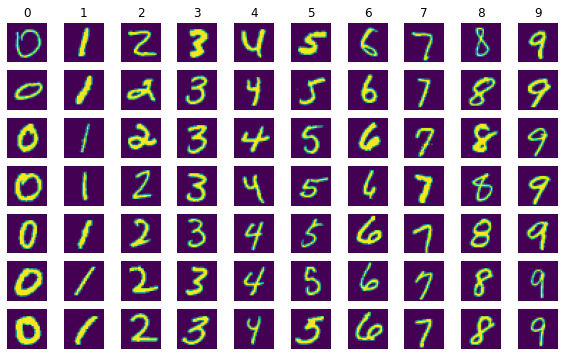

In [2]:
# Visualize some examples from the dataset.
# shows a few examples of training images from each class.
fig, ax = plt.subplots()
classes = ['0','1','2','3','4','5','6','7','8','9']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx,:])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
fig.set_figwidth(10)
fig.set_figheight(6)

To make sure the data is mean centered we'll calculate the mean from the training data and subtract it from training and testing set. This has the effect of centering the data cloud around the origin for every dimension, which helps with classification.

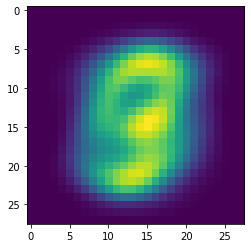

In [3]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
x_train,x_test = x_train.reshape(60000,784),x_test.reshape(10000,784)
mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28))) # visualize the mean image
plt.show()

Now we'll do dimensionality reduction, namely PCA, because training on a dataset with dimensions 60000 x 784 takes forever. To determine how many components to keep we'll use the explained_variance_ratio attribute which tells us how much of the variance each component explains. We should keep the number of components that accounts for at least 80% of the variance, from trial and error 85 components does just that.

In [4]:
n_components = 85
pca=PCA(n_components)
pca.fit(x_test)
X_train_pca=pca.transform(x_train)
X_test_pca=pca.transform(x_test)
print('Total variance explained by %d components = %s'% (n_components,np.sum(pca.explained_variance_ratio_)) )

Total variance explained by 85 components = 0.9016929368472917


Now we can train the classifier of the PCA reduced data and check accuracy. 

In [5]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train_pca, y_train)
predicted = svm_linear.predict(X_test_pca)
print('Accuracy = %s'% metrics.accuracy_score(y_true=y_test, y_pred=predicted))

Accuracy = 0.9443


Which is not so bad, to see the classifiers performance in detail we can plot a confusion matrix, which kind of show's where the classifier got it right and where it got confused. 

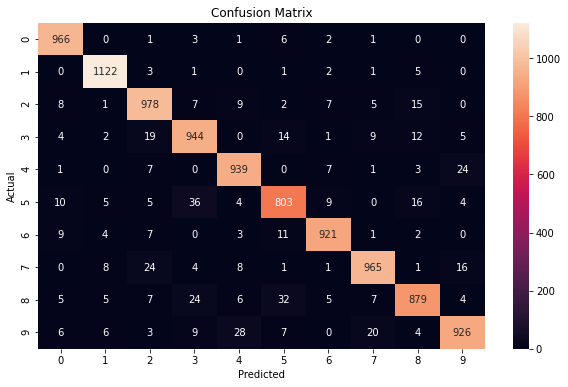

In [6]:
cm = confusion_matrix(y_test, predicted)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AS it can be seen above it mixes up 2 with 7 & 3, 3 with 8 & 5, 4 with 9, 5 with 8, 7 with 9. Which is understandable, in the worst case,5, it got 8 out of 10 right.    

## Part 2 :  Convolutional Neural Network

After importing the data I resized the images to 32 x 32 to match the original implementation. 

In [8]:
# reimport the data because we've done stuff to it in the previous task
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train0 = y_train
y_test0= y_test
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# rescale to match the original implementation
x_train, x_test = tf.image.resize(x_train,[32,32]),tf.image.resize(x_test,[32,32])
print('x_train: %s, x_test: %s'%(x_train.shape,x_test.shape))
print(f'Input image dimension: {x_train.shape[1:]}')
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ',x_test.shape)
print('Test labels shape: ', y_test.shape)

x_train: (60000, 32, 32, 1), x_test: (10000, 32, 32, 1)
Input image dimension: (32, 32, 1)
Training data shape:  (60000, 32, 32, 1)
Training labels shape:  (60000,)
Test data shape:  (10000, 32, 32, 1)
Test labels shape:  (10000,)


In [9]:
def myCNN():   
  model = tf.keras.models.Sequential()
  # First Layer
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu',input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))) 
  # Second Layer
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Flatten())
  # Fully-connected NNs
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=84, activation='relu'))
  model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))
  return model
print('Model Structure & Parameters:')
model = myCNN()
model.summary()

Model Structure & Parameters:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)            

Now that is set up we can try different loss function, optimizer combinations and compare their accuracy. We'll try out categorical cross entropy, mean squared error and hinge loss functions; And Adam, RMSprop , SGD and Adagrad optimizers. As for the hyperparameter's of the optimizers we'll use what I found optimal for each through some trial and error. Since we're doing 5 epochs this will take a while.     

### Hyperparameter tunning 

- Stochastic Gradient Descent

<img width="512" alt="MnistExamples" src="https://miro.medium.com/max/425/1*m1KQOLl-qB0mgRq_IWivnQ.png"/>

- Adaptive momentum method (Adam)

<img width="256" alt="MnistExamples" src="https://miro.medium.com/max/380/1*Ti-cvetTBXnTsM6rHUhmlg.png"/>

- Finding global minima

<img width="512" alt="MnistExamples" src="https://miro.medium.com/max/700/1*m7-otgfbxiAvSipInHliXw.gif"/>


#### Loss functions and optimizers

In [17]:
# Training Parameters
EPOCHS = 5
BATCH_SIZE = 256 #128 
df = pd.DataFrame(columns=['loss_fn','optimizer','train_accuracy','test_accuracy','epochs','batch_size'])
loss_fn = [tf.keras.losses.CategoricalCrossentropy() ,tf.keras.losses.MeanSquaredError(),tf.keras.losses.Hinge()]

optimizer = [tf.keras.optimizers.RMSprop(learning_rate=0.01 , rho=0.95 , momentum=0.03 , epsilon=1e-07),
             tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.995,epsilon=1e-07,amsgrad=False),
             tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.05, nesterov=True),
             tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07)]

for loss in loss_fn:
    for opt in optimizer:
        model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
        if loss.name  == 'categorical_crossentropy':
            y_train = tf.keras.utils.to_categorical(y_train0)
            y_test = tf.keras.utils.to_categorical(y_test0)
        print('loss_fn: %s,  optimizer: %s'% (loss.name , opt.__class__.__name__))
        model.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=0) # Verbose controls the output frequency during training
        train_loss, train_acc = model.evaluate(x_train, y_train)
        test_loss, test_acc = model.evaluate(x_test, y_test)
        df = df.append({'loss_fn': loss.name,
                        'optimizer': opt.__class__.__name__,
                        'train_accuracy': train_acc*100,
                        'test_accuracy': test_acc*100,
                        'epochs': EPOCHS,
                        'batch_size': BATCH_SIZE},ignore_index=True)
        print('Train accuracy:', train_acc)
        print('Test accuracy:', test_acc)

loss_fn: categorical_crossentropy,  optimizer: RMSprop
313/313 [==============================] - 2s 7ms/step - loss: 0.0462 - accuracy: 0.9875
Train accuracy: 0.9905833601951599
Test accuracy: 0.987500011920929
loss_fn: categorical_crossentropy,  optimizer: Adam
313/313 [==============================] - 3s 8ms/step - loss: 0.0387 - accuracy: 0.9908
Train accuracy: 0.9990833401679993
Test accuracy: 0.9908000230789185
loss_fn: categorical_crossentropy,  optimizer: SGD
313/313 [==============================] - 2s 7ms/step - loss: 0.0397 - accuracy: 0.9915
Train accuracy: 0.9995999932289124
Test accuracy: 0.9915000200271606
loss_fn: categorical_crossentropy,  optimizer: Adagrad
313/313 [==============================] - 2s 7ms/step - loss: 0.0399 - accuracy: 0.9917
Train accuracy: 0.9995999932289124
Test accuracy: 0.9916999936103821
loss_fn: mean_squared_error,  optimizer: RMSprop
313/313 [==============================] - 2s 7ms/step - loss: 0.0030 - accuracy: 0.9837
Train accuracy: 0.

In [18]:
df

,loss_fn,optimizer,train_accuracy,test_accuracy,epochs,batch_size
0,categorical_crossentropy,RMSprop,99.058336,98.750001,5,256
1,categorical_crossentropy,Adam,99.908334,99.080002,5,256
2,categorical_crossentropy,SGD,99.959999,99.150002,5,256
3,categorical_crossentropy,Adagrad,99.959999,99.169999,5,256
4,mean_squared_error,RMSprop,98.909998,98.369998,5,256
5,mean_squared_error,Adam,99.738336,99.010003,5,256
6,mean_squared_error,SGD,99.825001,99.070001,5,256
7,mean_squared_error,Adagrad,99.825001,99.059999,5,256
8,hinge,RMSprop,98.683333,98.060000,5,256
9,hinge,Adam,99.456668,98.890001,5,256


AS it can be seen above most combinations had performance that is about the same. Categorical cross entropy has a higher test accuracy with Adagrad, SGD and Adam in that order. Mean squared error had a very close results too, and hinge loss seems to have the lowest scores. But not by much as it can be seen from the plot below the bars almost form a straight line.

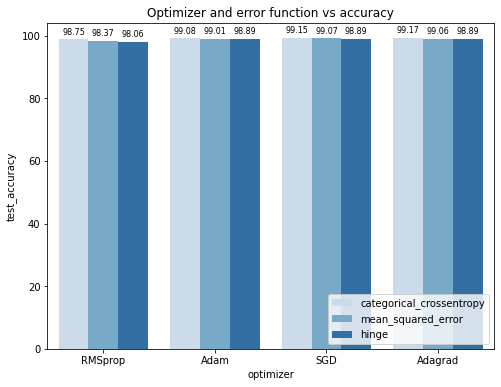

In [41]:
fig, ax = plt.subplots()
ax = sb.barplot(x='optimizer',y='test_accuracy',hue='loss_fn',data=df,palette="Blues")
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.legend(loc='lower right')
ax.set_title("Optimizer and error function vs accuracy")
fig.set_figwidth(8)
fig.set_figheight(6)

We can do something similar to the models activation functions, modify the model function to take in activation function and loop to find the most optimal. We'll take a look at sigmoid, tanh, ELU , ReLU and leaky ReLU while keeping categorical cross entropy and Adam as a loss function and optimizer, since the combination seems to be the best. Because we just want a rough comparison between the functions we don't have to train for five epochs and can reduce the batch size to 128. 

#### Activation function

In [21]:
def CNN(act):  
  model = tf.keras.models.Sequential()
  # First Layer
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation=act,input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # Second Layer
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation=act))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Flatten())
  # Fully-connected NNs
  model.add(tf.keras.layers.Dense(units=120, activation=act))
  model.add(tf.keras.layers.Dense(units=84, activation=act))
  model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))
  return model

In [23]:
# Training Parameters
EPOCHS = 2
BATCH_SIZE = 128 

df2 = pd.DataFrame(columns=['Activation function','train_accuracy','test_accuracy'])

leaky_relu =tf.keras.layers.LeakyReLU(alpha=0.01) # bc its a layer
act_fun = ['sigmoid','tanh','relu','elu',leaky_relu]
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.995,epsilon=1e-07,amsgrad=False)
          
for act in act_fun:
    model = CNN(act)
    if act == leaky_relu:
        act = leaky_relu.name
    print('activation_fun: %s'% act)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
    if loss == tf.keras.losses.categorical_crossentropy:
        y_train = tf.keras.utils.to_categorical(y_train0)
        y_test = tf.keras.utils.to_categorical(y_test0)
    model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=0) # Verbose controls the output frequency during training
    train_loss, train_acc = model.evaluate(x_train, y_train)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    df2 = df2.append({'Activation function': act,
                    'train_accuracy': train_acc*100,
                    'test_accuracy': test_acc*100 },ignore_index=True)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)

activation_fun: sigmoid
313/313 [==============================] - 2s 6ms/step - loss: 0.1442 - accuracy: 0.9571
Train accuracy: 0.955049991607666
Test accuracy: 0.957099974155426
activation_fun: tanh
313/313 [==============================] - 2s 7ms/step - loss: 0.0506 - accuracy: 0.9836
Train accuracy: 0.9875166416168213
Test accuracy: 0.9836000204086304
activation_fun: relu
313/313 [==============================] - 2s 6ms/step - loss: 0.0455 - accuracy: 0.9855
Train accuracy: 0.9841499924659729
Test accuracy: 0.9854999780654907
activation_fun: elu
313/313 [==============================] - 2s 6ms/step - loss: 0.0538 - accuracy: 0.9824
Train accuracy: 0.98416668176651
Test accuracy: 0.9824000000953674
activation_fun: leaky_re_lu_1
313/313 [==============================] - 2s 6ms/step - loss: 0.0399 - accuracy: 0.9866
Train accuracy: 0.9881666898727417
Test accuracy: 0.9865999817848206


In [24]:
df2

,Activation function,train_accuracy,test_accuracy
0,sigmoid,95.504999,95.709997
1,tanh,98.751664,98.360002
2,relu,98.414999,98.549998
3,elu,98.416668,98.240000
4,leaky_re_lu_1,98.816669,98.659998


As it can be seen above sigmoid seems to be the worst with 96% accuracy and everything else is just about the same with LeakyReLU having a slight edge. So when it comes to activation functions it seems best to stick with ReLU or Leaky ReLU and avoid sigmoid. 

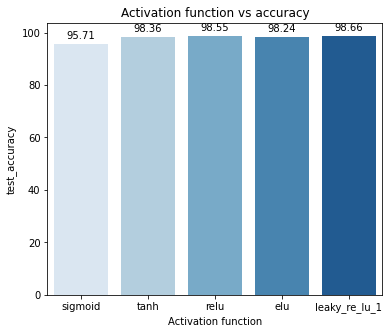

In [38]:
fig, ax = plt.subplots()
ax = sb.barplot(x='Activation function',y='test_accuracy',data=df2,palette="Blues")
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, 8),
                   textcoords='offset points')
ax.set_title("Activation function vs accuracy")
fig.set_figwidth(6)
fig.set_figheight(5)

Now that we've established the best combinations of hyperparameters we can fiddle with the architecture itself to make it better or worse. Let's start by adding more stuff. Since LeNet-5 had about 60,000 trainable parameters its natural to wonder, what if we have more parameters? Does that necessarily increase accuracy? 

We can find that out by constructing a network with about 80,000 trainable parameters. It'll will have four convolutional layers each followed by a pooling layer, except the fully connected layer. The first convolutional layer has 10 kernels of size 5, the second 16 of size 5 and the last 14 kernels of size 2. The fourth convolutional layer is a fully connected layer of 360 units. By the way all these numbers are completely arbitrary and I have no reason to believe they would result in a better performance.  

### Expansion

In [ ]:
def myCNN():
  model = tf.keras.models.Sequential()
  # First Layer
  model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=5, activation='relu',input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # Second Layer
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # Third Layer
  model.add(tf.keras.layers.Conv2D(filters=14, kernel_size=2, activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Flatten())
  # Fully-connected NNs
  model.add(tf.keras.layers.Dense(units=360, activation='relu'))
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=84, activation='relu'))
  model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))
  return model
print('Model Structure & Parameters:')
model = myCNN()
model.summary()

Model Structure & Parameters:
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 28, 28, 10)        260       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 14, 14, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 10, 10, 16)        4016      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 4, 4, 14)          910       
                                                                 
 max_pooling2d_66 (MaxP

Now we can do a short training with the best combinations we found earlier and then we can compare the original LeNet-5 with the network with more trainable parameters. 

In [33]:
# Training Parameters
EPOCHS = 5
BATCH_SIZE = 256 #128 
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.995,epsilon=1e-07,amsgrad=False)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
if loss_fn == tf.keras.losses.categorical_crossentropy:
    y_train = tf.keras.utils.to_categorical(y_train0)
    y_test = tf.keras.utils.to_categorical(y_test0)
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0) # Verbose controls the output frequency during training
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)


313/313 [==============================] - 2s 6ms/step - loss: 0.0585 - accuracy: 0.9802
Train accuracy: 0.9868666529655457
Test accuracy: 0.9801999926567078


Categorical cross entropy and Adam had a train and test accuracy of 99.908334 and 99.080002, So it looks like I've made it slightly worse by adding 20,000 more parameters, which wasn't what I expected at all. 

Okay, since just adding more weights doesn't seem to improve performance, what is the least amount of parameters we can have and still maintain a reasonable accuracy?  
We can strip the network down and see what that'll do to performance. This time we'll only have two convolutional layers with 6 kernels of size 2. And we'll make the first fully connected layer have only 42 units, because its a good number. 

### Ablation

In [30]:
def CNN_():
  model = tf.keras.models.Sequential()
  # First Layer
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=2, activation=leaky_relu,input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # Second Layer
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=2, activation=leaky_relu))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Flatten())
  # Fully-connected NNs
  model.add(tf.keras.layers.Dense(units=42, activation=leaky_relu))
  #model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))
  return model
print('Model Structure & Parameters:')
model = CNN_()
model.summary()

Model Structure & Parameters:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 31, 31, 6)         30        
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 6)         150       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 7, 6)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 294)               0         
                                                                 
 dense_21 (Dense)       

In [32]:
# Training Parameters
EPOCHS = 5
BATCH_SIZE = 256 #128 
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.995,epsilon=1e-07,amsgrad=False)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
if loss_fn == tf.keras.losses.categorical_crossentropy:
    y_train = tf.keras.utils.to_categorical(y_train0)
    y_test = tf.keras.utils.to_categorical(y_test0)
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0) # Verbose controls the output frequency during training
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)


313/313 [==============================] - 2s 6ms/step - loss: 0.0658 - accuracy: 0.9782
Train accuracy: 0.9821000099182129
Test accuracy: 0.9782000184059143


That's quite a respectable performance for a network with just 13,000 parameters. I suspect we can still remove more stuff and maintain a reasonable accuracy. I also experimented a little with drop out and generally it reduced training accuracy a little and improved test accuracy a little too. 
